Даны 3 колонки с данными:
    - 'Name' - уникальное название заявки, пришедшей в центр технической поддержки.
    - 'Start Date' - время поступления заявки.
    - 'End Date' - время обработки заявок.
Необходимо рассчитать еще одну колонку - 'Implementation time', показывающую количество рабочих часов (https://en.wikipedia.org/wiki/Business_hours), потраченных на обработку каждой заявки.
Рабочие часы начинаются в 08:00 и заканчиваются в 18:00. Рабочая неделя ПН-ПТ, есть праздники (РФ).

- Самостоятельно сгенерировать случайные 
        'Name', 'Start Date' и 'End Date' при условии 01-01-2019 <= 'Start Date' <= 'End Date' < 01-01-2020 
        (N датасетов, где размер датасета 10^N, N < 8 - натуральное).
- По исходным данным построить гистограмму "сколько поступило и обработано заявок по месяцам".
- Построить график скорости работы вашей программы в зависимости от N.
- Написать тесты с пояснениями.

In [2]:
import pandas as pd
import datetime
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
def generate_year(freq='30'):
    
    russian_holidays = [
        '2019-01-01','2019-01-02','2019-01-03','2019-01-04','2019-01-05','2019-01-06','2019-01-07',
        '2019-01-08','2019-02-23','2019-02-24','2019-03-08','2019-03-09','2019-03-10','2019-05-01',
        '2019-05-02','2019-05-03','2019-05-04','2019-05-05','2019-05-09','2019-05-10','2019-05-11',
        '2019-05-12','2019-06-12','2019-11-04', '2020-01-01'
    ]

    russian_holidays = list(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date(), russian_holidays))
    
    the_whole_year = pd.DataFrame(pd.date_range(start='2019-01-01', end='2020-01-01', freq=f'{freq}min', name='timestamp'))
    
    the_whole_year['is_holiday'] = the_whole_year['timestamp'].dt.date.isin(russian_holidays)
    the_whole_year['is_working_day'] = the_whole_year['timestamp'].dt.weekday.isin(range(5))
    the_whole_year['is_working_hour'] = (the_whole_year['timestamp'].dt.hour<=18)&\
                                        (the_whole_year['timestamp'].dt.hour>=8)
    the_whole_year['to_count'] = (~the_whole_year['is_holiday'])&\
                                 the_whole_year['is_working_day']&\
                                 the_whole_year['is_working_hour']
    return the_whole_year


In [18]:
def generate_tickets(N, year, freq):
    year_len = len(year)
    tickets = []
    for i in range(10**N):
        start=np.random.randint(year_len-1)
        end=np.random.randint(start+1, year_len)
        start_time = year['timestamp'].iloc[start]
        end_time = year['timestamp'].iloc[end]
        periods = len(year[(year['timestamp'].between(start_time, end_time))&
                   (year['to_count'])]['timestamp'])
        tickets.append([i, start_time, end_time, periods*freq/60])

    df = pd.DataFrame(tickets, columns=['name', 'start_time', 'end_time', 'implementation_time'])
    return df

In [19]:
def draw_plot(tickets):
    tickets['start_month'] = tickets['start_time'].dt.month
    tickets['end_month'] = tickets['end_time'].dt.month
    ends = tickets[tickets['start_month']==tickets['end_month']]['start_month']
    starts = tickets['start_month']

    sns.histplot(starts, color="skyblue", bins=20)
    sns.histplot(ends, color="red", bins=20)
    return plt

Checking 0
Checking 1
Checking 2
Checking 3
Checking 4
Checking 5


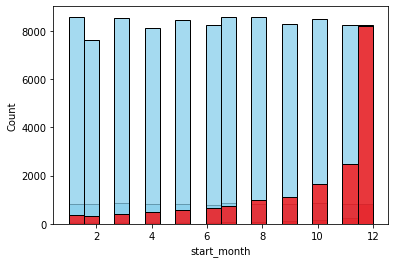

In [20]:
deltas = []
freq = 30
year = generate_year(freq)
N = 6

for i in range(N):
    print(f'Checking {i}')
    time1 = time.time()
    tickets = generate_tickets(i, year, freq)
    plt = draw_plot(tickets)
    time2 = time.time()
    deltas.append([i, time2-time1])
    
perfomance = pd.DataFrame(deltas, columns=['N', 'perfomance_time'])


/home/reeve/Code/PycharmProjects/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


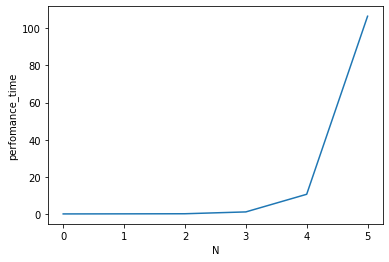

In [6]:
sns.lineplot(perfomance.N, perfomance.perfomance_time)
plt.show()

Test of the dataset generation

The test checks if in the geberated dataset were the same implementation
times with different closing time

In [21]:
year = generate_year()

#uncomment if you want to check only working hours
#otherwise it will show all simil
year = year[year['to_count']]

df = generate_tickets(2, year, 30)
df_len = len(df)

In [22]:
lines = []
freq = 30
n = 1000
year_len = len(year)
start=np.random.randint(year_len-1)
start_time = year['timestamp'].iloc[start]
print(f'Generating dataset from {start_time}')
for i in range(n):
    end=np.random.randint(start+1, year_len)
    end_time = year['timestamp'].iloc[end]
    to_count = year['to_count'].iloc[end]
    periods = len(year[(year['timestamp'].between(start_time, end_time))&
               (year['to_count'])]['timestamp'])
    lines.append([start_time, end_time, periods*freq/60, to_count])
test_df = pd.DataFrame(lines, columns=['start_time', 'end_time', 'implementation_time', 'to_count'])
test_df_len = len(test_df)

tests = []
for t in range(n*10):
    randoms = np.random.randint(test_df_len, size=2)
    line1=test_df.iloc[randoms[0]]
    line2=test_df.iloc[randoms[1]]
    test = ~(line1['end_time'] > line2['end_time']) ^ (line1['implementation_time'] > line2['implementation_time'])
    if test!=-1:
        print('Equal impl time: ', line1['end_time'], line2['end_time'], line1['implementation_time'], [line1['to_count'], line2['to_count']])
        tests.append(test)

if len(tests)==0:
    print('No bugs in lines generations')
else:
    print('Equal impl time detected')

Generating dataset from 2019-01-29 14:30:00
No bugs in lines generations
